In this notebook I'll explore the data called "The Ultimate Netflix TV Shows and Movies (2022 Updated)" by going through the process of preliminary data visualization, defining a goal, developing a model on a training set, testing the model on a validation set, finally fit my finished model to the full data set and prepare presentation visualizations.
This data set is found on Kaggle on 12/7/2022

In [1]:
# Import my packages, 
# numpy for math, pandas for data, 
# matplotlib.pyplot for Matlab like visualizations, seaborn for fancier visualizations, Statsmodels for easy QQ Plots 
# sqldf for SQL syntax in Pandas
# sklearn packages for machine learning
# statsmodels for summaries on linear model
import numpy as np 
import pandas as pd 
import itertools
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import statsmodels.api as sm
import pandasql as psql
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
file_paths =[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#read the files into pandas dataframes and give them easy to use names
data_set_names = ["bm_net_data", "credits_data", "titles_data", "bm_year_data", 
                  "bs_year_data", "bs_net_data"]
for  (name, file) in zip(data_set_names, file_paths):
    # read the file into a dataframe
    df = pd.read_csv(file, index_col= "index")
    # create a new variable with the convient names
    exec(name + "=df")
print(len(bm_year_data))
bm_year_data.head()


49


,TITLE,RELEASE_YEAR,SCORE,MAIN_GENRE,MAIN_PRODUCTION
index,,,,,
0,White Christmas,1954,7.5,romance,US
1,The Guns of Navarone,1961,7.5,war,US
2,My Fair Lady,1964,7.8,drama,US
3,Bonnie and Clyde,1967,7.7,drama,US
4,Dirty Harry,1971,7.7,thriller,US


Data exploration starts with understanding your variables by creating summary statistics and looking at some initial visualizations.

Details of the data: The Best Movie By Year file contains the best movie by year as determined by IMDB score and number of votes

TITLE: The title of the movie or TV show. (String)
RELEASE_YEAR: The year the movie or TV show was released. (Integer)
SCORE: The IMDB score for the movie or TV show. (Float)
MAIN_GENRE: The main genre of the movie or TV show. (String)
MAIN_PRODUCTION: The main production company of the movie or TV show. (String)

In [2]:
#a few descriptive statistics about the Best Movie by Year data
print("Overall the IMDB scores ranged from ", bm_year_data.SCORE.min(), "to ", bm_year_data.SCORE.max(), "over the years ", bm_year_data.RELEASE_YEAR.min(), " and ",bm_year_data.RELEASE_YEAR.max() )
print("The average score was", np.around(bm_year_data.SCORE.mean(), decimals=3), " and the standard deviation was ", np.around(bm_year_data.SCORE.std(), decimals=3))

#Use a query to find the best movies
best_movies=psql.sqldf("""select * 
                       from bm_year_data 
                       where SCORE = (select max(SCORE) from bm_year_data)""")

print("There was", len(best_movies), "with the highest rank.")
print("The highest rated movie was ", best_movies.TITLE[0], "with a IMDB score of ",best_movies.SCORE[0] )
print("It was released in ", best_movies.RELEASE_YEAR[0],"and was of the ", best_movies.MAIN_GENRE[0], "genera.")


Overall the IMDB scores ranged from  5.8 to  9.0 over the years  1954  and  2022
The average score was 7.871  and the standard deviation was  0.633
There was 1 with the highest rank.
The highest rated movie was  David Attenborough: A Life on Our Planet with a IMDB score of  9.0
It was released in  2020 and was of the  documentary genera.


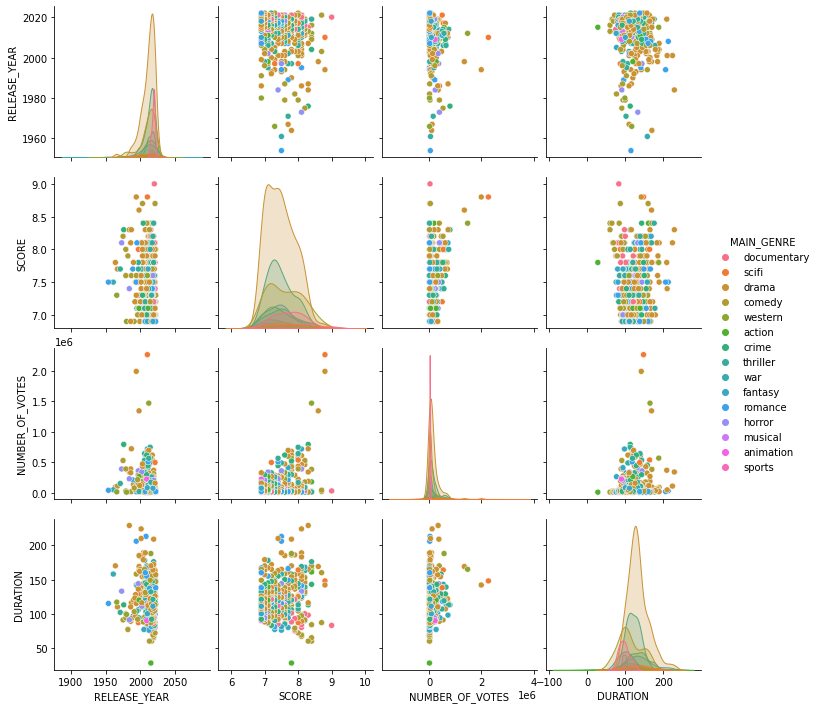

In [3]:
# a few descriptive graphs
#bivariate graphs
sns.pairplot(bm_net_data, hue= 'MAIN_GENRE')

Text(0, 0.5, 'Frequency')

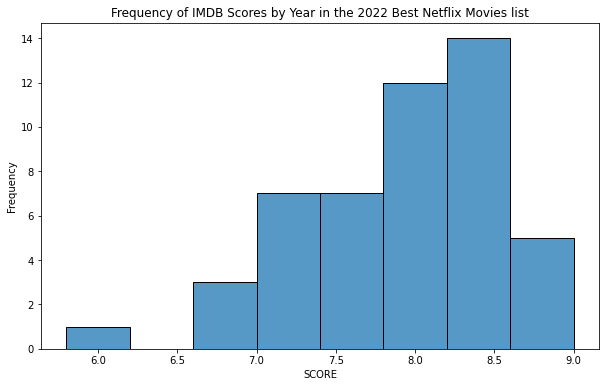

In [4]:

# focusing in on scores
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Frequency of IMDB Scores by Year in the 2022 Best Netflix Movies list")

# Histogram showing distribution of scores
sns.histplot(data=bm_year_data, x='SCORE')

# Add label for vertical axis
plt.ylabel("Frequency")



Text(0.5, 1.0, 'Genres in the 2022 Best Netflix Movies list')

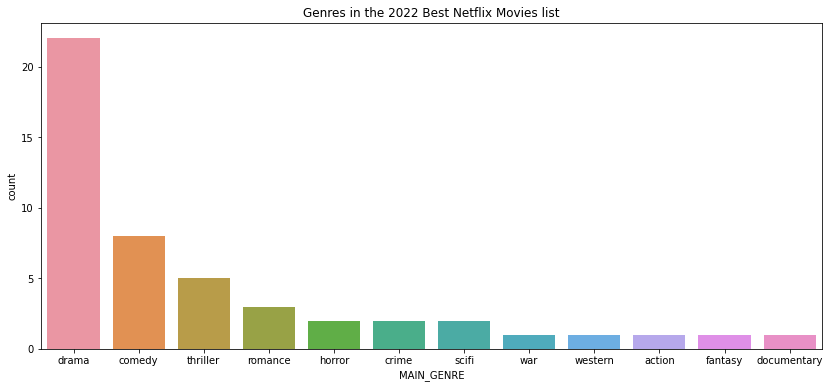

In [5]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

#Bar chart showing distribution of genres
sns.countplot(data=bm_year_data, 
              x='MAIN_GENRE', 
              order =bm_year_data['MAIN_GENRE'].value_counts().index)

# Add title
plt.title("Genres in the 2022 Best Netflix Movies list")



Text(0.5, 1.0, 'Genres in the 2022 Best Netflix Movies list')

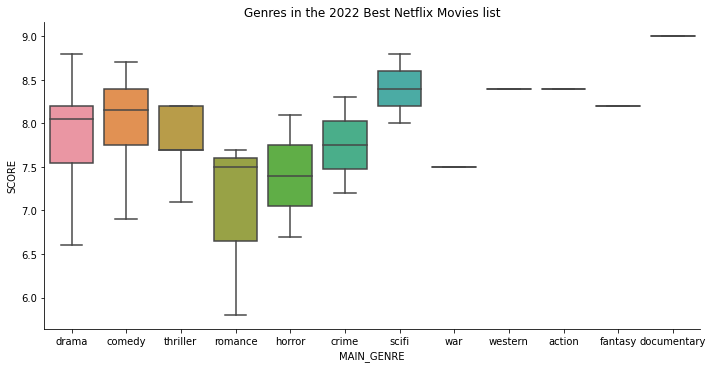

In [6]:
# box plots for genres
# Set the width and height of the figure
#plt.figure(figsize=(14,6))

#Bar chart showing distribution of genres
sns.catplot(data=bm_year_data, 
            x='MAIN_GENRE',
            y='SCORE', 
            order =bm_year_data['MAIN_GENRE'].value_counts().index, 
            kind = 'box', 
            aspect = 2)

# Add title
plt.title("Genres in the 2022 Best Netflix Movies list")


<AxesSubplot:xlabel='RELEASE_YEAR', ylabel='SCORE'>

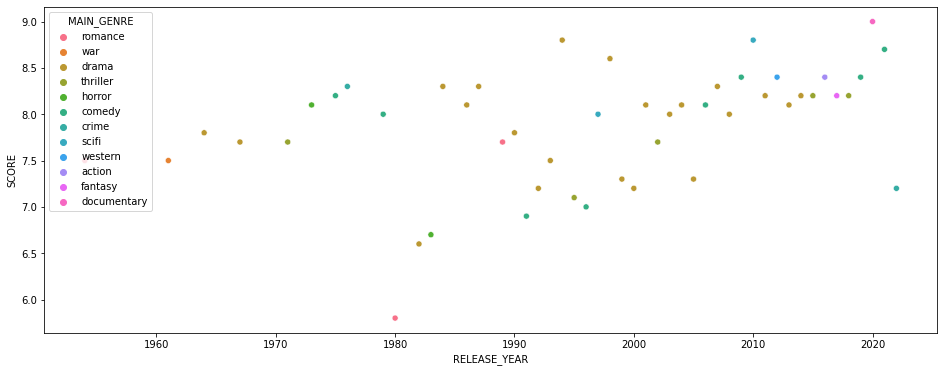

In [7]:
# Set the width and height of the figure
plt.figure(figsize=(16,6))
#Scatter plot of IMDB  Year vs Score
sns.scatterplot(data=bm_year_data, 
                x='RELEASE_YEAR', 
                y='SCORE', 
                hue='MAIN_GENRE')

#bar chart of MAIN_PRODUCTION i.e. location
#box plots of scores based on genre

#scatter plot of scores vs years

Let's continue the process of exploratory descriptive statistics with the other data sets!

In [8]:
#Best Movie 
#a few descriptive statistics about the Best Movie on Netflix data
print("Overall the IMDB scores ranged from ", bm_net_data.SCORE.min(), "to ", bm_net_data.SCORE.max(), "over the years ", bm_net_data.RELEASE_YEAR.min(), " and ",bm_net_data.RELEASE_YEAR.max() )
print("The average score was", np.around(bm_net_data.SCORE.mean(), decimals=3), " and the standard deviation was ", np.around(bm_net_data.SCORE.std(), decimals=3))

#Use a query to find the best movies
best_movies=psql.sqldf("""select * 
                       from bm_net_data 
                       where SCORE = (select max(SCORE) from bm_net_data)""")

print("There was", len(best_movies), "with the highest rank.")
print("The highest rated movie was ", best_movies.TITLE[0], "with a IMDB score of ",best_movies.SCORE[0] )
print("It was released in ", best_movies.RELEASE_YEAR[0],"and was of the ", best_movies.MAIN_GENRE[0], "genera.")

#Best Show by Year
#Best Show
#credits
#titles

Overall the IMDB scores ranged from  6.9 to  9.0 over the years  1954  and  2022
The average score was 7.509  and the standard deviation was  0.442
There was 1 with the highest rank.
The highest rated movie was  David Attenborough: A Life on Our Planet with a IMDB score of  9.0
It was released in  2020 and was of the  documentary genera.


I suspect that the Best Movies By Year Netflix data set is a subset of the Best Movies Netflix data set. Let's explore that.

In [9]:
#Inner merge the tables to see if bm_year_data is a subset of bm_net_data


same_bm = psql.sqldf('''SELECT y.TITLE,y.RELEASE_YEAR, n.TITLE , n.RELEASE_YEAR      
      FROM bm_year_data y
      INNER JOIN bm_net_data n 
     ON y.TITLE = n.TITLE''' ) 
#Every movie is listed twice, so just keep the distict years
unique_same_bm = psql.sqldf('''SELECT DISTINCT RELEASE_YEAR, TITLE FROM same_bm''')

#From the original data keep just Release Year and Title
year_bm = psql.sqldf('''SELECT  y.RELEASE_YEAR  , y.TITLE     
      FROM bm_year_data y''')

#compare the two sets
print("There are ", len(year_bm), " values in the Best Movies By Year data set.")
print("There are ",len(unique_same_bm), " values in common between the Netflix Best Movies data set and the By Year data set")
#list values that are not in both sets
print("The following movies are the ones not in both sets")
print(pd.concat([unique_same_bm,year_bm]).drop_duplicates(keep=False))

#use the bm_net_data to create a list of best movies for each year from that data, see if it's the same missing movies
net_bm_by_year = psql.sqldf('''SELECT TITLE, RELEASE_YEAR, MAX(SCORE)
            FROM bm_net_data
            GROUP BY RELEASE_YEAR''')
#compare my newly made best movie by year with the original best movie by year set
print("There are ", len(net_bm_by_year), " values that have the highest rank grouped by year in the Netflix Best Movies data set")
print("There are ", len(bm_year_data), " values in the original By Year data set")

#compare the new best by year of list I made with the original best by year
net_bm_y = psql.sqldf('''SELECT  y.RELEASE_YEAR  , y.TITLE     
      FROM net_bm_by_year y''')
print("The following movies are the ones not in both sets")
print(pd.concat([net_bm_y,year_bm]).drop_duplicates(keep=False))

There are  49  values in the Best Movies By Year data set.
There are  47  values in common between the Netflix Best Movies data set and the By Year data set
The following movies are the ones not in both sets
    RELEASE_YEAR            TITLE
9           2016        Christine
9           1980  The Blue Lagoon
10          1982            Annie
11          1983        Christine
There are  49  values that have the highest rank grouped by year in the Netflix Best Movies data set
There are  49  values in the original By Year data set
The following movies are the ones not in both sets
    RELEASE_YEAR                                        TITLE
3           1966                            The Professionals
10          1980                              The Long Riders
11          1982      Monty Python Live at the Hollywood Bowl
21          1995                                       Bombay
28          2002                   The Legend of Bhagat Singh
29          2003                           

Let's check my understanding of the relationship between these data sets. I believe Christine 1983, and The Professionals 1966 is not in the larger Netflix Best Movie Data set, and that best IMDB is insufficient to determine membership to the Best Movie By Year data set for several years. 

In [10]:
#Check my understanding of the set
def Christine_check(data2):
    chris= psql.sqldf('''SELECT * 
                  FROM data2 
                  WHERE TITLE = 'Christine'
                  ''')
    print(chris)
#Christine_check(bm_net_data)
#Christine_check(bm_year_data)


#Christine_check(bm_year_data)
#So Christine 2016 is in the Netflix large data set but the 1983 version is not, the opposite is true for the By Year set
def year_check(year):
    by_year= psql.sqldf(f'''SELECT * 
                  FROM bm_year_data 
                  WHERE RELEASE_YEAR = {year}
                  ''')
    net= psql.sqldf(f'''SELECT * 
                  FROM bm_net_data 
                  WHERE RELEASE_YEAR = {year}
                  ''')
    print("by year has", by_year)
    print("from Netflix has", net)
year_check(1982)
#By year was missing The Professionals 1966,
#the two sets each only had one movie for 1980 and 1982  they are different movies
#The other difference seem to be because I made my best list on score only and didn't include weight for score.


by year has    index  TITLE  RELEASE_YEAR  SCORE MAIN_GENRE MAIN_PRODUCTION
0     10  Annie          1982    6.6      drama              US
from Netflix has    index                                    TITLE  RELEASE_YEAR  SCORE  \
0     79  Monty Python Live at the Hollywood Bowl          1982    7.9   

   NUMBER_OF_VOTES  DURATION MAIN_GENRE MAIN_PRODUCTION  
0            15186        77     comedy              GB  


So while the Best Movies Netflix data set and the Best Movies By Year data set have many similar values the Best Movie By Year is not a subset of the the Best Movies Netflix data set. There were a few movies that were listed in the best by year but not in the larger Netflix data set. IMDB score is not the only thing that determined if a movie was the best that year, there is also weight placed on number of scores.

Text(0, 0.5, 'Frequency')

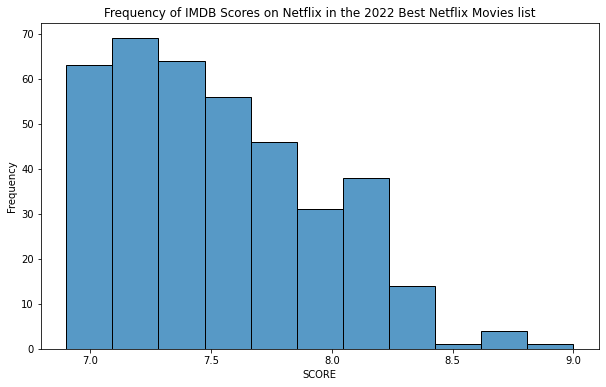

In [11]:
#first a bar chart of scores
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Frequency of IMDB Scores on Netflix in the 2022 Best Netflix Movies list")

# Histogram showing distribution of scores
sns.histplot(data=bm_net_data, x='SCORE')

# Add label for vertical axis
plt.ylabel("Frequency")

Text(0.5, 1.0, 'Genres in the 2022 Best Netflix Movies list')

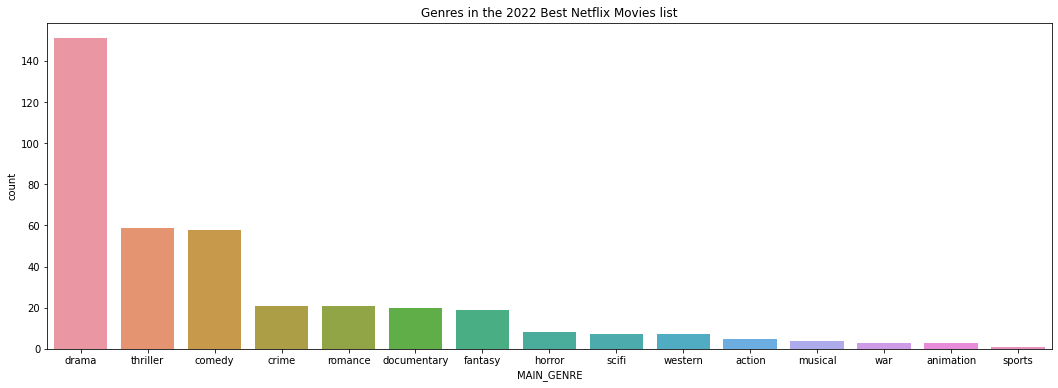

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(18,6))

#Bar chart showing distribution of genres
sns.countplot(data=bm_net_data, 
              x='MAIN_GENRE', 
              order =bm_net_data['MAIN_GENRE'].value_counts().index)

# Add title
plt.title("Genres in the 2022 Best Netflix Movies list")


Text(0.5, 1.0, 'Genres in the 2022 Best Netflix Movies list')

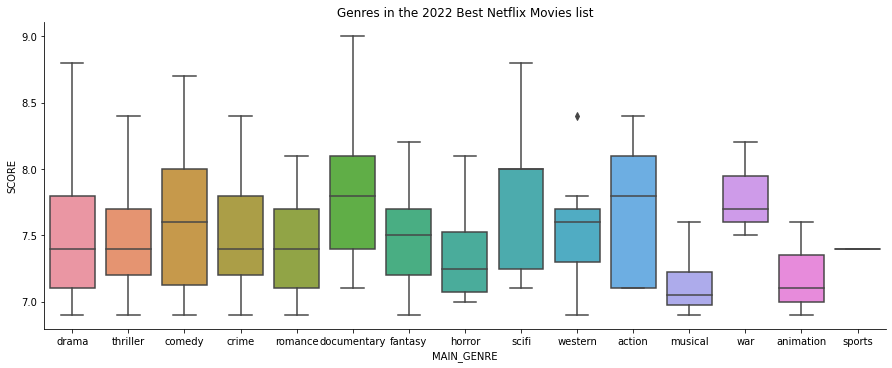

In [13]:
#box plots for genres
# Set the width and height of the figure
#plt.figure(figsize=(14,6))

#Bar chart showing distribution of genres
sns.catplot(data=bm_net_data, 
            x='MAIN_GENRE',
            y='SCORE', 
            order =bm_net_data['MAIN_GENRE'].value_counts().index, 
            kind = 'box', 
            aspect = 2.5)

# Add title
plt.title("Genres in the 2022 Best Netflix Movies list")


<AxesSubplot:xlabel='DURATION', ylabel='SCORE'>

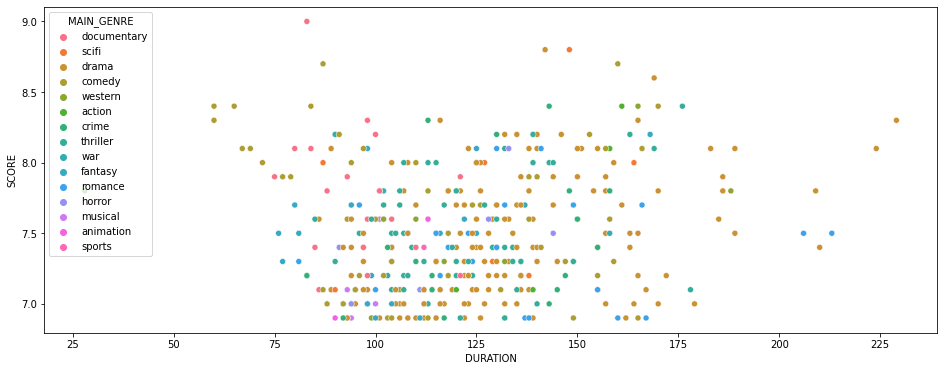

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(16,6))
#Scatter plot of IMDB  Year vs Score

sns.scatterplot(data=bm_net_data, 
                x='DURATION', 
                y='SCORE', 
                hue='MAIN_GENRE')


Now let's use this data to make some buisness decisions and predictions!
Interesting question: What attributes will predict the highest IMDB scores?

I'll develop a model first by starting with all features. Then using the MAE as a validation critera I'll play with the features. Finally I'll do cross validation to see that my model performs well outside the training set.



In [15]:
# Build a model to predict IMDB score
# I'll use the Best Movie Netflix data set rather than By Year based on it having many more data values.
y = bm_net_data.SCORE
# First I'll fit a full model with all features.
# TITLE will be excluded because it is almost always unique. 
# Perhaps in later feature engineering I could search for common words within the title.

# Defining the features
full_features = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_GENRE', 'MAIN_PRODUCTION']
X_cat = bm_net_data[full_features]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

#Fit the model
# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

#Evaluate the success of the model using MAE
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print(len(rf_val_predictions)==len(val_y))
print("Validation MAE for Random Forest Model: {:,.6f}".format(rf_val_mae))




True
Validation MAE for Random Forest Model: 0.266010


Let's run cross-validation on the full model

In [16]:
my_pipeline = Pipeline(steps=[
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])
# Multiply by -1 since sklearn calculates *negative* MAE
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

MAE scores:
 [0.73635897 0.36766667 0.20498701 0.25275325 0.53075325]
0.4185038295038298


Let's look at how the predicted values compare to the actuals

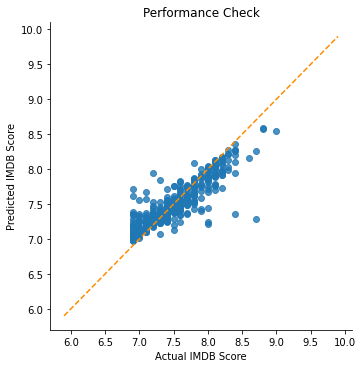

In [17]:
# Checking residuals to investigate low Durbin-Watson
# Add residuals to our data set

# a copy of the data to assoicate with this model
rf_data = pd.DataFrame(bm_net_data['SCORE'])
rf_data['PREDICT']=rf_model.predict(X)



# Plotting the observed vs predicted values
sns.lmplot(x= 'SCORE', y='PREDICT', data=rf_data, fit_reg=False, height=5)
    
# Plotting the diagonal line
line_coords = np.arange(rf_data[['SCORE', 'PREDICT']].min().min()-1, 
                        rf_data[['SCORE', 'PREDICT']].max().max()+1)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

plt.ylabel('Predicted IMDB Score')
plt.xlabel('Actual IMDB Score')
plt.title('Performance Check')
plt.show()

In [18]:
#Now I'll fit a simpler model just using the numerical variables
num_features = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION']
X = bm_net_data[num_features]


# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

#Fit the model
# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

#Evaluate the success of the model using MAE
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print(len(rf_val_predictions)==len(val_y))
print("Validation MAE for Random Forest Model: {:,.4f}".format(rf_val_mae))

True
Validation MAE for Random Forest Model: 0.3015


In [19]:
#Fitting a categorical only model
# Defining the features
cat_features = [ 'MAIN_GENRE', 'MAIN_PRODUCTION']
X_cat = bm_net_data[cat_features]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

#Fit the model
# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

#Evaluate the success of the model using MAE
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print(len(rf_val_predictions)==len(val_y))
print("Validation MAE for Random Forest Model: {:,.4f}".format(rf_val_mae))

True
Validation MAE for Random Forest Model: 0.3582


In [20]:
#Fitting less than full but using intuition
intu_features = [ 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_GENRE', 'MAIN_PRODUCTION']
X_intu = bm_net_data[intu_features]
# One-hot coding categorical variables
X = pd.get_dummies(X_intu)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

#Fit the model
# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

#Evaluate the success of the model using MAE
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print(len(rf_val_predictions)==len(val_y))
print("Validation MAE for Random Forest Model: {:,.6f}".format(rf_val_mae))

True
Validation MAE for Random Forest Model: 0.275361


Interesting YEAR seems to have the smallest impact on MAE. I suspect some overfitting due to this being a smallish data set. Let's run cross validation on the model excluding year to see how it holds up with different training data.

In [21]:
my_pipeline = Pipeline(steps=[
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])
# Multiply by -1 since sklearn calculates *negative* MAE
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

MAE scores:
 [0.72417949 0.35794872 0.19394805 0.26080519 0.54379221]
0.4161347319347322


Being a statistician at heart I would rather not use intuition when I can apply theory. Here I will use RFEC to aid in feature selection.

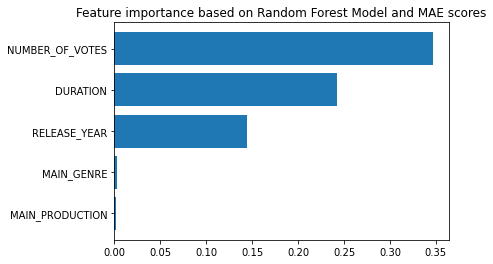

In [22]:
# Reset my X to be the full list of possible features
full_features = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_GENRE', 'MAIN_PRODUCTION']
X_cat = bm_net_data[full_features]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

# Fit the model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
# Plot feature importance
f_i = list(zip(full_features,rf_model.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.title("Feature importance based on Random Forest Model and MAE scores")
plt.show()

This suggests that the categorical variables MAIN_GENRE and MAIN_PRODUCTION are of least importance, so I'll revisit the numerical only random forest model and run cross validation on it.

In [23]:
#Now I'll fit a simpler model just using the numerical variables
num_features = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION']
X = bm_net_data[num_features]


# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

#Fit the model
# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
# Cross validation
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

MAE scores:
 [0.77015385 0.37279487 0.18787013 0.29036364 0.56415584]
0.43706766566766564


It's curious that the model suggest by the feature importance method under performs the model that only excludes year. I suspect it has to do with the handeling of categorical variables. With one-hot encoding each categorical variable is represented by many dummy variables, which adds complexity to the model at a coding level but is still rather simple at human understanding level. 

We do see that of the numerical variables RELEASE_YEAR was the least important, so this supports my intuition.

Looking at a different modeling approach let's explore with some linear models. 



In [24]:
# playing with some GLM models
# redefine the data set just to be sure it's full and fresh
y = bm_net_data.SCORE
# First I'll fit a full model with all features.
# TITLE will be excluded because it is almost always unique. 
# Perhaps in later feature engineering I could search for common words within the title.

# Defining the features
full_features = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION','MAIN_GENRE', 'MAIN_PRODUCTION']
X_cat = bm_net_data[full_features]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

# Fit the Linear Model
lin_model = LinearRegression()
lin_model.fit(train_X, train_y)
lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

MAE scores:
 [0.65965658 0.27244243 0.20360262 0.29544047 0.55875452]
0.3979793234914492


The linear model is performing better than the random forest models, let's explore some more. 

In [25]:
print(f'model score on training data: {lin_model.score(train_X, train_y)}')
print(f'model score on validation data: {lin_model.score(val_X, val_y)}')

model score on training data: 0.35392076710461107
model score on validation data: 0.2198979050017088


Low R^2 values. Let's investigate the importance of each of the features.The one hot coded categorical variables are so numerous it's hard to see what's going on. Below we'll just look at the numerical variables

MAE scores:
 [0.76463367 0.27797226 0.11089481 0.34655456 0.62247928]
0.4245069148073366


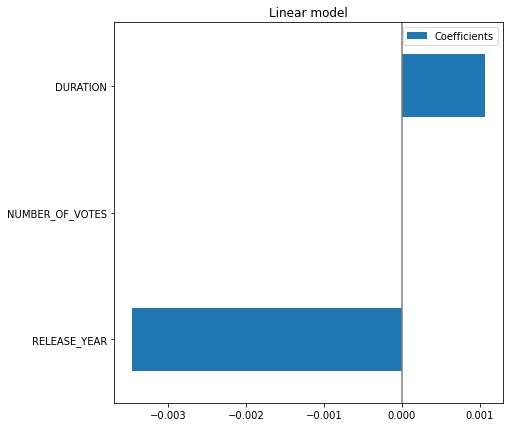

In [26]:
num_features = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION']
X=bm_net_data[num_features]
# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

# Fit the Linear Model
lin_model = LinearRegression()
lin_model.fit(train_X, train_y)
lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())
train_X_num = train_X[num_features]
coefs = pd.DataFrame(
   lin_model.coef_,
   columns=['Coefficients'], index=train_X_num.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [27]:
intu_features = ['RELEASE_YEAR','NUMBER_OF_VOTES', 'MAIN_GENRE', 'MAIN_PRODUCTION']
X_intu = bm_net_data[intu_features]
# One-hot coding categorical variables
X = pd.get_dummies(X_intu)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()
# Fit the Linear Model
intu_lin_model = LinearRegression()
intu_lin_model.fit(train_X, train_y)
intu_lin_val_predictions = intu_lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())
print(f'model score on training data: {intu_lin_model.score(train_X, train_y)}')
print(f'model score on validation data: {intu_lin_model.score(val_X, val_y)}')

MAE scores:
 [0.66074052 0.27273672 0.20356463 0.29603889 0.55863174]
0.3983425014622161
model score on training data: 0.35309376321410424
model score on validation data: 0.2203306210611331


Sitting with my models for some time I think the categorical variables aren't being best utilized due to the high cardinality and many of those categories having low frequency. Therefore I'm going to reduce the cardinality by choosing the top N categories and then renaming the other categories to "other"

In [28]:
# Feature engineer new Main Production with "Other" category in the bm_net_data set
# First define the Production levels to keep
keep_P = bm_net_data.MAIN_PRODUCTION.value_counts().index[:3] # I fussed and fiddled to come up with top 3

# Add the new column to the existing data frame
bm_net_data['MAIN_P_other'] = np.where(
                              bm_net_data.MAIN_PRODUCTION.isin(keep_P),
                              bm_net_data.MAIN_PRODUCTION, 'Other')

# Check that things went the way I planned
valCount_P = bm_net_data.MAIN_P_other.value_counts()
#print (valCount_P)

# Feature engineer new Main Genre with "Other" category in the bm_net_data set
keep_G = bm_net_data.MAIN_GENRE.value_counts().index[:10] #lots of trial and error to find this number

# Add the new column to the existing data fram
bm_net_data['MAIN_G_other'] = np.where(bm_net_data.MAIN_GENRE.isin(keep_G),bm_net_data.MAIN_GENRE, 'Other')

valCount_G = bm_net_data.MAIN_G_other.value_counts()
print (valCount_G)


drama          151
thriller        59
comedy          58
crime           21
romance         21
documentary     20
fantasy         19
Other           16
horror           8
scifi            7
western          7
Name: MAIN_G_other, dtype: int64


Now lets how these newly engineered features perform!

In [29]:
# Build a model using the reduced categorical variables
# Define my response
y = bm_net_data.SCORE

# First I'll fit a full model with the new versions of the categorical features.
# Defining the features
full_features_o = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_G_other', 'MAIN_P_other']
X_cat = bm_net_data[full_features_o]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)


#Fit the model
# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

#Evaluate the success of the model using MAE
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print(len(rf_val_predictions)==len(val_y))
print("Validation MAE for Random Forest Model: {:,.6f}".format(rf_val_mae))

my_pipeline = Pipeline(steps=[
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])
# Multiply by -1 since sklearn calculates *negative* MAE
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())


True
Validation MAE for Random Forest Model: 0.275557
MAE scores:
 [0.74592308 0.35835897 0.18935065 0.26319481 0.54935065]
0.4212356310356312


Hmm, performs slightly worse. Let's look at the feature importance.

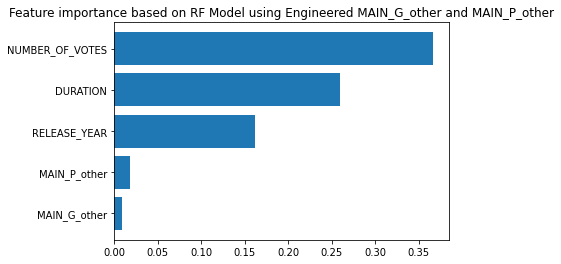

In [30]:
# Plot feature importance
f_i = list(zip(full_features_o,rf_model.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.title("Feature importance based on RF Model using Engineered MAIN_G_other and MAIN_P_other")
plt.show()

They do have more importance now, particularly MAIN_P_other, but still much less importance than the numerical variables. Let's try a model that removes MAIN_G_other.

In [31]:
# Build a model using the reduced categorical variables
# Define my response
y = bm_net_data.SCORE

# First I'll fit a reduced model with the new versions of the categorical features.
# Defining the features
red_features_o = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_P_other']
X_cat = bm_net_data[red_features_o]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
train_X.head()

#Fit the model
# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

#Evaluate the success of the model using MAE
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print(len(rf_val_predictions)==len(val_y))
print("Validation MAE for Random Forest Model: {:,.6f}".format(rf_val_mae))

my_pipeline = Pipeline(steps=[
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])
# Multiply by -1 since sklearn calculates *negative* MAE
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

True
Validation MAE for Random Forest Model: 0.287897
MAE scores:
 [0.75389744 0.36182051 0.18511688 0.27285714 0.55966234]
0.4266708624708624


Oof, worse still. Let's see how these engineered features perform in a linear model.

In [32]:

# Let's fit a linear full model with the new versions of the categorical features.
# Defining the features
full_features_o = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_G_other', 'MAIN_P_other']
X_cat = bm_net_data[full_features_o]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

# Fit the Linear Model
lin_model = LinearRegression()
lin_model.fit(train_X, train_y)
lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

MAE scores:
 [0.67462754 0.2566747  0.15615704 0.29384088 0.57409854]
0.3910797405131753


Nice! This is performing better than the Full Random Forest model, and the full linear model. Let's look at the correlation values.

other model score on training data: 0.2753826095600759
other model score on validation data: 0.2641983963472099


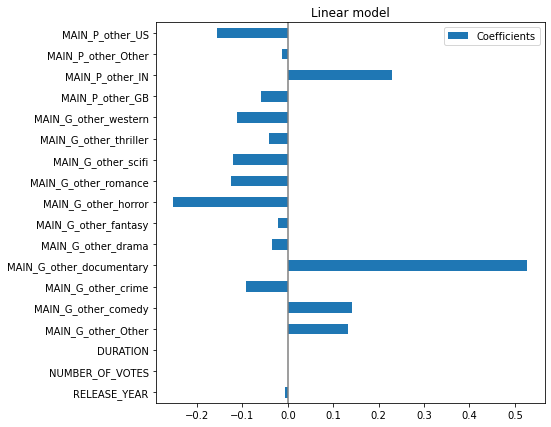

In [33]:
print(f'other model score on training data: {lin_model.score(train_X, train_y)}')
print(f'other model score on validation data: {lin_model.score(val_X, val_y)}')

coefs = pd.DataFrame(
   lin_model.coef_,
   columns=['Coefficients'], index=train_X.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

I'm seeing big coefficients on the categorical variables, let's look at a categorical linear model.

In [34]:
# Defining the features
cat_features_o = [ 'MAIN_G_other', 'MAIN_P_other']
X_cat = bm_net_data[cat_features_o]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Fit the Linear Model
cat_lin_model = LinearRegression()
cat_lin_model.fit(train_X, train_y)
cat_lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())


MAE scores:
 [0.83661859 0.37596154 0.17727273 0.38734781 0.64947621]
0.4853353742611556


Step in the wrong direction. The best current model is the general linear model with the categorical variables reduced using an "Other" category.

Let's check the validity of assumptions for the GLM.


In [35]:
# Fit the best performing model with all possible data
# Using the Statsmodel library because it has lots of lovely diagnostics

full_features_o = ['RELEASE_YEAR', 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_G_other', 'MAIN_P_other']
X_cat = bm_net_data[full_features_o]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

olsmod = sm.OLS(y, X).fit()
print(olsmod.summary())

                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     8.817
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           2.58e-18
Time:                        05:39:12   Log-Likelihood:                -170.08
No. Observations:                 387   AIC:                             374.2
Df Residuals:                     370   BIC:                             441.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
RELEASE_YEAR            

The F-statistic is significant with a probability much smaller than 5% so thats good. The T-statistic for duration is not significant so there is a potential to remove that and simplify the model. The Durbin-Watson score is very low, so there is some auto correlation. There are warnings about the covariance matrix and possible multicollinearity. Those will be the next things I investigate.

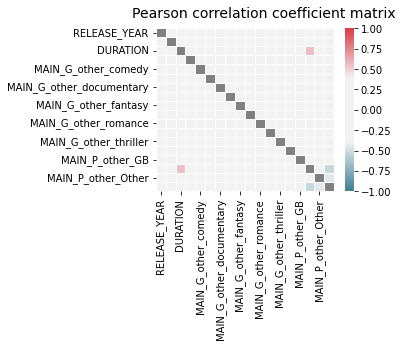

In [36]:
# Checking for multicollinearity
# Generate a mask for the diagonal cell
corr = X.corr()
#print('Pearson correlation coefficient matrix of each variables:\n', corr)

mask = np.zeros_like(corr, dtype=bool)
np.fill_diagonal(mask, val=True)

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(4, 3))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
cmap.set_bad('grey')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
fig.suptitle('Pearson correlation coefficient matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
# fig.tight_layout()

This also suggests Duration isn't serving the model. I'll run a new model without duration see if it still performs well with cross validation and MAE.

In [37]:
# Linear model Removing DURATION with the new versions of the categorical features.
# Defining the features
new_features_o = ['RELEASE_YEAR', 'NUMBER_OF_VOTES',  'MAIN_G_other', 'MAIN_P_other']
X_cat = bm_net_data[new_features_o]
# One-hot coding categorical variables
X_win = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X_win, y, random_state = 1)

# Fit the Linear Model
lin_model = LinearRegression()
lin_model.fit(train_X, train_y)
lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X_win, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

MAE scores:
 [0.67463868 0.25653236 0.15645208 0.29417959 0.5734378 ]
0.391048102565575


Nice, better still! Let's check the residuals are approximately normal.

In [38]:
winning_model = sm.OLS(y, X_win).fit()
print(winning_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     9.413
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           8.93e-19
Time:                        05:39:13   Log-Likelihood:                -170.18
No. Observations:                 387   AIC:                             372.4
Df Residuals:                     371   BIC:                             435.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
RELEASE_YEAR            

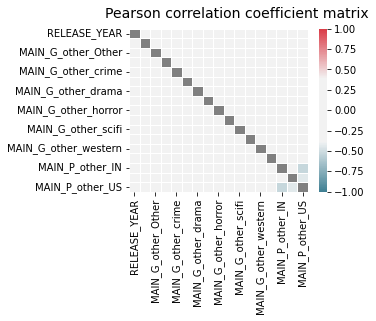

In [39]:
# Checking for multicollinearity
# Generate a mask for the diagonal cell
corr = X_win.corr()
#print('Pearson correlation coefficient matrix of each variables:\n', corr)

mask = np.zeros_like(corr, dtype=bool)
np.fill_diagonal(mask, val=True)

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(4, 3))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
cmap.set_bad('grey')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
fig.suptitle('Pearson correlation coefficient matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
# fig.tight_layout()

In [40]:
# Production could still be causing some multicolineararity problems
# A model without Main_Production
# Linear model Removing DURATION with the new versions of the categorical features.
# Defining the features
new_features_o = ['RELEASE_YEAR', 'NUMBER_OF_VOTES',  'MAIN_G_other']
X_cat = bm_net_data[new_features_o]
# One-hot coding categorical variables
X = pd.get_dummies(X_cat)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

# Fit the Linear Model
lin_model = LinearRegression()
lin_model.fit(train_X, train_y)
lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

MAE scores:
 [0.75230918 0.25565598 0.13294015 0.34715192 0.60286051]
0.4181835488063655


In [41]:
olsmod = sm.OLS(y, X).fit()
print(olsmod.summary())

                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     7.115
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           1.03e-11
Time:                        05:39:14   Log-Likelihood:                -192.79
No. Observations:                 387   AIC:                             411.6
Df Residuals:                     374   BIC:                             463.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
RELEASE_YEAR            

Ooof removing production really negatively impacted performance. Better to have a little colinnearity. 

The winning model is the General Linear Model using categorical variables that have been reduced in cardinality by using an "Other" category. Let's continue analyzing the conditions of the winning model with hopes of finding solutions to the unmet assumptions.

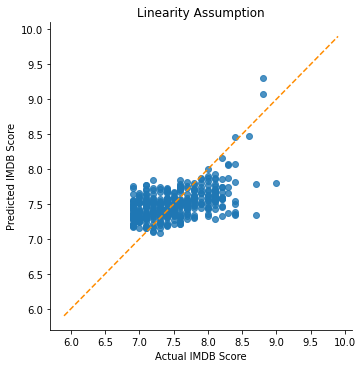

In [42]:
# Checking residuals to investigate low Durbin-Watson
# Add residuals to our data set
winning_model.predict(X_win)
# a copy of the data to assoicate with this model
win_bm_net_data = bm_net_data
win_bm_net_data['predict'] = winning_model.predict(X_win)
win_bm_net_data['residuals'] = winning_model.resid


# Plotting the observed vs predicted values
sns.lmplot(x= 'SCORE', y='predict', data=win_bm_net_data, fit_reg=False, height=5)
    
# Plotting the diagonal line
line_coords = np.arange(win_bm_net_data[['SCORE', 'predict']].min().min()-1, 
                        win_bm_net_data[['SCORE', 'predict']].max().max()+1)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

plt.ylabel('Predicted IMDB Score')
plt.xlabel('Actual IMDB Score')
plt.title('Linearity Assumption')
plt.show()

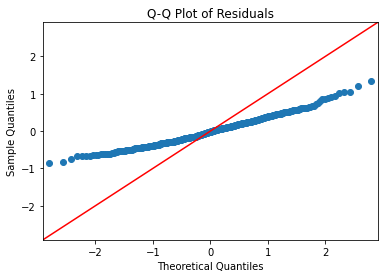

In [43]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(win_bm_net_data['residuals'], line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()


This is very illuminating! I can see a few high scoring movies are drastically influencing my model! Ultimately as a buisness we want to have high scoring movies, so these deserve more attention. It's the 6 movies with the top IMDB score that really seems out of wack. What are those movies?

In [44]:
top_Score = bm_net_data.nlargest(10,'SCORE')
interesting_features = ['TITLE', 'RELEASE_YEAR', 'SCORE', 'NUMBER_OF_VOTES', 'MAIN_GENRE', 'MAIN_PRODUCTION']
top_Score_interest = top_Score[interesting_features]
print(top_Score_interest)

                                          TITLE  RELEASE_YEAR  SCORE  \
index                                                                  
0      David Attenborough: A Life on Our Planet          2020    9.0   
1                                     Inception          2010    8.8   
2                                  Forrest Gump          1994    8.8   
3                                    Anbe Sivam          2003    8.7   
4                            Bo Burnham: Inside          2021    8.7   
5                           Saving Private Ryan          1998    8.6   
6                              Django Unchained          2012    8.4   
7                                        Dangal          2016    8.4   
8                        Bo Burnham: Make Happy          2016    8.4   
9                         Louis C.K.: Hilarious          2010    8.4   

       NUMBER_OF_VOTES   MAIN_GENRE MAIN_PRODUCTION  
index                                                
0                31180  doc

I'm thinking there is a behavior for the masses and a behavior for the really good movies that is just a bit more wild, what influencers call "Chasing the "IT" factor". So for funsies I'll separate the best of the best movies from the more run of the mill movies. 

In [45]:
less_than_bm = bm_net_data[bm_net_data['SCORE']< 8.4]
#less_than_bm.head()
# Define the target
y_less = less_than_bm['SCORE']
# Defining the features
new_features_o = ['RELEASE_YEAR', 'NUMBER_OF_VOTES',  'MAIN_G_other', 'MAIN_P_other']
X_cat_less = less_than_bm[new_features_o]
# One-hot coding categorical variables
X_less = pd.get_dummies(X_cat_less)

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X_less, y_less, random_state = 1)

# Fit the Linear Model
lin_model = LinearRegression()
lin_model.fit(train_X, train_y)
lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X_less, y_less,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())

less_lin_model = sm.OLS(y_less, X_less).fit()
print(less_lin_model.summary())

#fit a linear model to this less than best data set


MAE scores:
 [0.65172203 0.26581692 0.15191205 0.27104083 0.53453562]
0.37500548880060297
                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     8.317
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           2.65e-16
Time:                        05:39:15   Log-Likelihood:                -129.04
No. Observations:                 373   AIC:                             290.1
Df Residuals:                     357   BIC:                             352.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

Hmm, I don't like that the R-square values went down. Let's look at the graph that made me think to remove those hight scores.

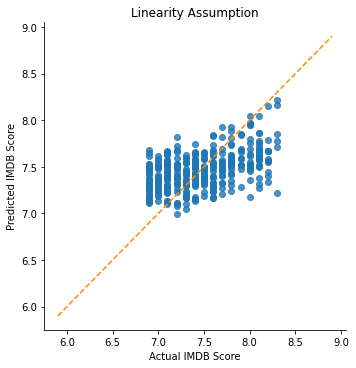

In [46]:
# Checking residuals to investigate low Durbin-Watson
# Add residuals to our data set
#less_lin_model.predict(X_less)
# a copy of the data to assoicate with this model
less_model_data = pd.DataFrame(less_than_bm)
#less_model_data.head
less_model_data['predict'] = less_lin_model.predict(X_less)
less_model_data['residuals'] = less_lin_model.resid


# Plotting the observed vs predicted values
sns.lmplot(x= 'SCORE', y='predict', data=less_model_data, fit_reg=False, height=5)
    
# Plotting the diagonal line
line_coords = np.arange(less_model_data[['SCORE', 'predict']].min().min()-1, 
                        less_model_data[['SCORE', 'predict']].max().max()+1)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

plt.ylabel('Predicted IMDB Score')
plt.xlabel('Actual IMDB Score')
plt.title('Linearity Assumption')
plt.show()

That absolutely did not fix the problem and I eliminated valuable data...Let's try a log transform.

In [47]:
log_y = np.log(bm_net_data['SCORE'])
# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X_win, log_y, random_state = 1)

# Fit the Linear Model
log_lin_model = LinearRegression()
log_lin_model.fit(train_X, train_y)
log_lin_val_predictions = lin_model.predict(val_X)
# cross validation
my_pipeline = Pipeline(steps=[
                              ('model', LinearRegression())
                             ])
scores =  -1*cross_val_score(my_pipeline, X_win, log_y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print(scores.mean())
log_winning_model = sm.OLS(log_y, X_win).fit()
print(log_winning_model.summary())

MAE scores:
 [0.08732158 0.0351517  0.02043094 0.03863233 0.07821091]
0.05194948989054245
                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     9.077
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           4.72e-18
Time:                        05:39:16   Log-Likelihood:                 613.22
No. Observations:                 387   AIC:                            -1194.
Df Residuals:                     371   BIC:                            -1131.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

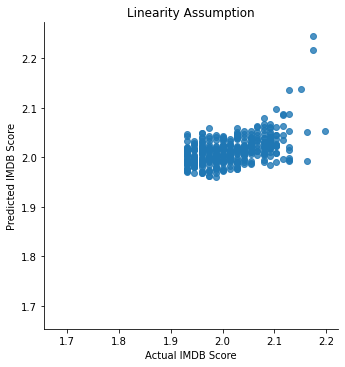

In [48]:
win_bm_net_data['log_predict'] = log_winning_model.predict(X_win)
win_bm_net_data['log_residuals'] = log_winning_model.resid
win_bm_net_data['log_SCORE'] = np.log(bm_net_data['SCORE'])

# Plotting the observed vs predicted values
sns.lmplot(x= 'log_SCORE', y='log_predict', data=win_bm_net_data, fit_reg=False, height=5)
    
# Plotting the diagonal line
line_coords = np.arange(win_bm_net_data[['log_SCORE', 'log_predict']].min().min()-0.25, 
                        win_bm_net_data[['log_SCORE', 'log_predict']].max().max()+0.25)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

plt.ylabel('Predicted IMDB Score')
plt.xlabel('Actual IMDB Score')
plt.title('Linearity Assumption')
plt.show()

Future work: Do IMDB scores relate to bigger profits for studios. For that I would need profits for many of these shows and movies. Ideally IMDB scores and profits for movies beyond the top watched for Netflix 2022